# Wrangle: Acquire & Prepare

<hr style="border:2px solid gray">

### Exercises I
Let's review the steps we take at the beginning of each new module.

1. Create a new repository named regression-exercises in your GitHub; all of your Regression work will be housed here.
2. Clone this repository within your local codeup-data-science directory.
3. Create a .gitignore and make sure your list of 'files to ignore' includes your env.py file.
4. Ceate a README.md file that outlines the contents and purpose of your repository.
5. Add, commit, and push these two files.
6. Now you can add your env.py file to this repository to access the Codeup database server.
7. For these exercises, you will create wrangle.ipynb and wrangle.py files to hold necessary functions.
8. As always, add, commit, and push your work often.

### Exercises II
Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.
2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaningful; remember to document your process and decisions using markdown and code commenting where helpful.
3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from env import user, password, host
import os

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

### #1. Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

In [2]:
#connect to sql zillow database
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"

#use this query to get desired info    
sql_query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    WHERE propertylandusetypeid = 261'''

In [3]:
#assign the variable 
df = pd.read_sql(sql_query, url)

In [4]:
#take a look at the data
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


<b>We can turn this into its own module
    <br>
--->acquire.py</b>

In [6]:
#Acquire.py

# Create helper function to get the necessary connection url.
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
    
def get_zillow_data():
    '''
    This function reads in the Zillow data from the Codeup db
    and returns a pandas DataFrame with cbedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips
    for all Single Family Residential properties.
    '''
    
    zillow_query = '''
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    WHERE propertylandusetypeid = 261
    '''
    return pd.read_sql(zillow_query, get_connection('zillow'))

<hr style="border:1px solid black">

### #2. Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaningful; remember to document your process and decisions using markdown and code commenting where helpful.

<b>Step 1: Clean the data</b>

In [7]:
#take a look at our columns
df.columns.tolist()

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount',
 'fips']

In [8]:
#let's rename the columns to be more readable
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

<b>Step 2: Deal with nulls</b>

In [9]:
#find nulls in each column
df.isnull().sum()

bedrooms        11
bathrooms       11
area          8484
tax_value      493
year_built    9337
taxamount     4442
fips             0
dtype: int64

In [10]:
df.shape

(2152863, 7)

<b>Note</b>:
    <br>
- ```bedrooms``` and ```bathrooms``` is less than .001% null
- ```area``` is 0.4% null
- ```tax_value``` is 0.02% null
- ```year_built``` is 0.4% null
- ```taxamount``` is 0.2% null

<br>
Therefore, dropping our nulls would be our best bet in this case.

In [11]:
#drop nulls
df = df.dropna()

In [12]:
#make sure all our nulls are nulls dropped
df.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
taxamount     0
fips          0
dtype: int64

<b>Step 3: Handle outliers</b>

bedrooms


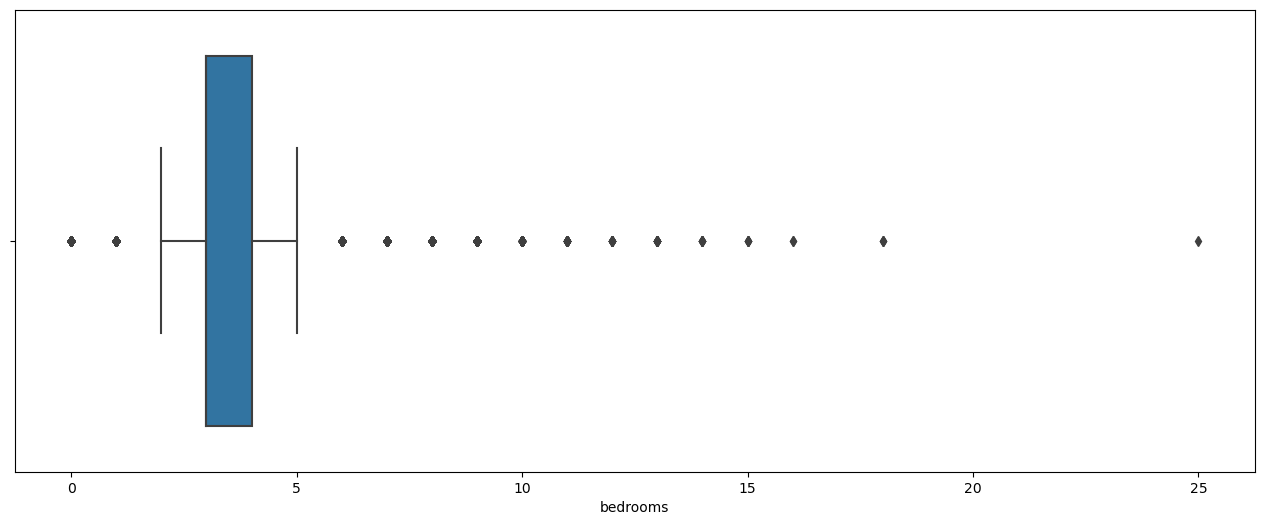

bathrooms


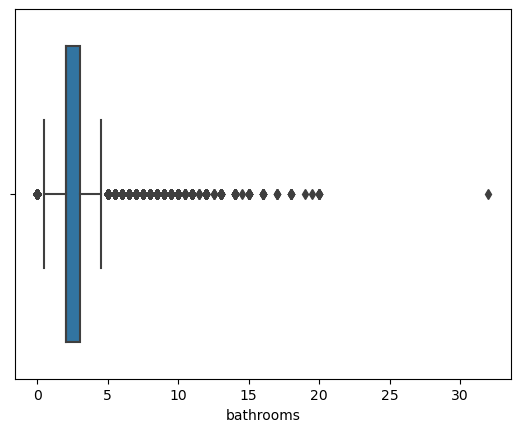

area


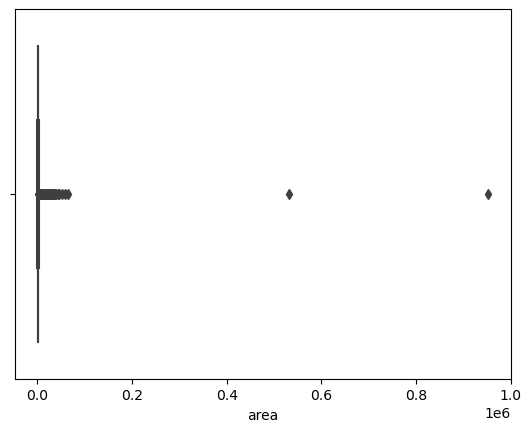

tax_value


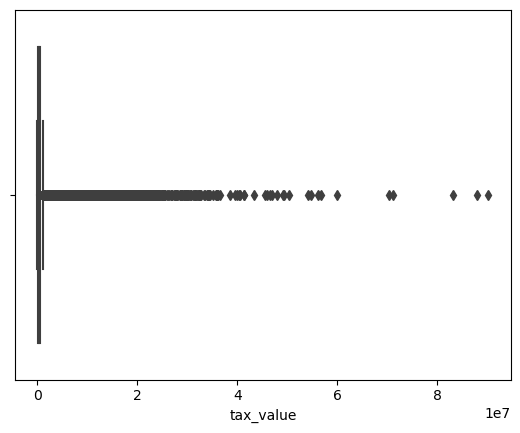

year_built


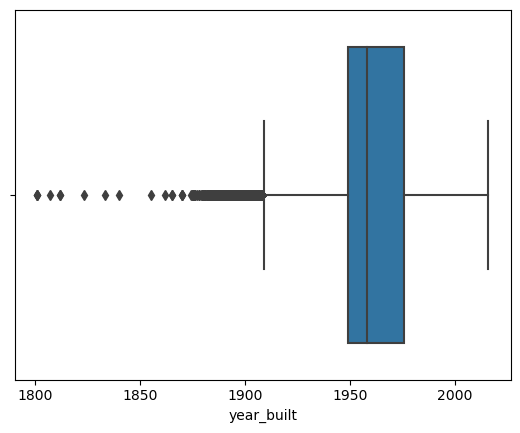

In [13]:
# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built']

for col in cols:
    print(col)
    sns.boxplot(x=col, data=df)
    plt.show()

<b>Note</b>:
    <br>
    -- It looks like there are some outliers in this data.
    <br>
    -- We need to determine what to do.

<b>Step 4: Split the data</b>

In [14]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [15]:
#take a look at the split dataframes
train.shape, validate.shape, test.shape

((1198531, 7), (513657, 7), (428047, 7))

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192919 entries, 553191 to 1333156
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1192919 non-null  float64
 1   bathrooms   1192919 non-null  float64
 2   area        1192919 non-null  float64
 3   tax_value   1192919 non-null  float64
 4   year_built  1192919 non-null  float64
 5   taxamount   1192919 non-null  float64
 6   fips        1192919 non-null  float64
dtypes: float64(7)
memory usage: 72.8 MB


<b>We can turn this into its own module
    <br>
--->prepare.py</b>

In [17]:
#prepare.py

def prep_zillow(df):
    '''
    This function takes in the zillow df acquired by get_zillow_file
    Returns a cleaned zillow df.
    '''
    #change column names to be more legible
    df = df.rename(columns={'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})
    
    #drop null values- at most there were 9000 nulls (this is only 0.5% of 2.1M)
    df = df.dropna()

    #drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df

### #3. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values in your wrangle.py file. Name your final function wrangle_zillow.

<b>Now, let's add ```acquire.py``` and ```prepare.py``` together into a ```wrangle.py```</b>


In [18]:
#wrangle.py

def acquire_zillow():
    '''
    This function checks to see if zillow.csv already exists, 
    if it does not, one is created
    '''
    #check to see if telco_churn.csv already exist
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    
    else:

        #creates new csv if one does not already exist
        df = get_zillow_data()
        df.to_csv('zillow.csv')

    return df

def prep_zillow(df):
    '''
    This function takes in the zillow df
    then the data is cleaned and returned
    '''
    #change column names to be more readable
    df = df.rename(columns={'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

    #drop null values- at most there were 9000 nulls (this is only 0.5% of 2.1M)
    df = df.dropna()

    #drop duplicates
    df.drop_duplicates(inplace=True)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    return train, validate, test


def wrangle_zillow():
    '''
    This function uses the acquire and prepare functions
    and returns the split/cleaned dataframe
    '''
    train, validate, test = prep_zillow(acquire_zillow())
    
    return train, validate, test

In [19]:
#try our new wrangle module
train, validate, test = wrangle_zillow()

In [20]:
#take a look at the split dataframes
train.shape, validate.shape, test.shape

((1192919, 7), (511252, 7), (426043, 7))